In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing

In [3]:
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg19 import VGG19, preprocess_input

In [28]:
content_img = '/content/drive/MyDrive/CV_HA6_7/butterfly_content_image.jpeg'
style_img = '/content/drive/MyDrive/CV_HA6_7/rainbow_design.jpeg'
target_size=(224,224)

In [29]:
width, height = (224,224) ## shape of input/content image
img_no_rows = 224 ##rows of generated image
img_no_cols = int(width * img_no_rows / height) ##calculating columns of generated image

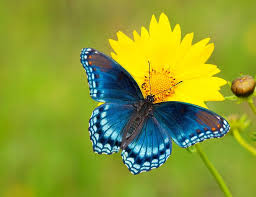

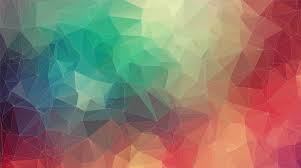

In [30]:
from IPython.display import Image, display
display(Image(content_img))
display(Image(style_img))

In [31]:
def preprocess_input_image(img_path, target_size):  
  array = load_img(
      img_path, target_size=target_size
  )
  array = keras.preprocessing.image.img_to_array(array)
  array = np.expand_dims(array, axis=0)
  return tf.convert_to_tensor(preprocess_input(array))

In [32]:
style = preprocess_input_image(style_img, target_size)
content = preprocess_input_image(content_img, target_size)
#generated = preprocess_input_image(generated_, target_size)

In [33]:
print(style.shape)
print(content.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)


In [34]:
def deprocess_generated_image(array):
    array = array.reshape((img_no_rows, img_no_cols, 3))
    array[:, :, 0] += 103.939
    array[:, :, 1] += 116.779
    array[:, :, 2] += 123.68
    array = array[:, :, ::-1]
    array = np.clip(array, 0, 255).astype("uint8")
    return array

### **For Vgg19**

In [95]:
model_19 = VGG19(include_top=False, weights="imagenet")
model_19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [96]:
all_layers = dict([(layer.name, layer.output) for layer in model_19.layers])
feature_extractor = keras.Model(inputs=model_19.inputs, outputs=all_layers)
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layer = ["block5_conv2"]

### **For Vgg16**

In [35]:
from keras.applications.vgg16 import VGG16, preprocess_input
model_16 = VGG16(include_top=False, weights="imagenet")
model_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [36]:
all_layers_16 = dict([(layer.name, layer.output) for layer in model_16.layers])
feature_extractor_16 = keras.Model(inputs=model_16.inputs, outputs=all_layers_16)
style_layers_16 = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layer_16 = ["block5_conv2"]

alpha - weight for content loss

beta - weight for style loss


In [37]:

def s_loss(style, generated):
  style = tf.transpose(style,(2,0,1))
  features_s = tf.reshape(style, (tf.shape(style)[0],-1))
  gram_s = tf.matmul(features_s, tf.transpose(features_s))
  generated = tf.transpose(generated,(2,0,1))
  features_g = tf.reshape(generated, (tf.shape(generated)[0],-1))
  gram_g = tf.matmul(features_g, tf.transpose(features_g))
  img_size = img_no_rows * img_no_cols
  out = tf.reduce_sum(tf.square(gram_s-gram_g)) / (4.0 * (3**2)*(img_size**2))
  return out

In [38]:
def Loss_function(content, style, generated):
  input_tensor = tf.concat([content, style, generated], axis=0) ##concatinating 3 image matrices row-wise
  alpha = 1e-6 ##Content loss from the features we extracted
  beta = 2e-8
  loss_out = tf.constant(0.0)
  features = feature_extractor_16(input_tensor) ##extracting features
  features_atlayer = features[content_layer_16[0]]
  content_img_feature = features_atlayer[0,:,:,:]
  generated_img_feature = features_atlayer[2,:,:,:]
  loss_out = loss_out + alpha*(tf.reduce_sum(tf.square(generated_img_feature-content_img_feature)))
  print(loss_out)
  for layer in style_layers_16:  ##Style loss from the features we extracted 
    features_atlayer = features[layer]
    style_img_feature = features_atlayer[1,:,:,:]
    generated_img_feature = features_atlayer[2,:,:,:]
    loss_out = loss_out + (beta/len(style_layers_16))*s_loss(style_img_feature, generated_img_feature)
    print(loss_out)
  return loss_out

In [39]:
generated = tf.Variable(style)
with tf.GradientTape() as tape:
  #tape.watch(generated)
  loss = Loss_function(content, style, generated)
grad = tape.gradient(loss, generated)

tf.Tensor(128.11365, shape=(), dtype=float32)
tf.Tensor(128.11365, shape=(), dtype=float32)
tf.Tensor(128.11365, shape=(), dtype=float32)
tf.Tensor(128.11365, shape=(), dtype=float32)
tf.Tensor(128.11365, shape=(), dtype=float32)
tf.Tensor(128.11365, shape=(), dtype=float32)


In [40]:
print(grad)

tf.Tensor(
[[[[ 4.0802061e-05  2.0454998e-05  1.8496095e-05]
   [ 6.2814048e-05  1.0967604e-05  1.7569448e-05]
   [ 2.4744875e-05 -4.9699491e-05 -3.6894697e-05]
   ...
   [ 8.6250620e-05 -5.9253714e-05  2.5973537e-05]
   [ 1.6891932e-04  5.5902728e-05  1.3436528e-04]
   [ 1.4718424e-04  1.0011243e-04  1.4213542e-04]]

  [[ 1.6718578e-04  1.4817441e-04  1.3329297e-04]
   [ 1.6909049e-04  7.3920753e-05  8.0878483e-05]
   [ 1.4473123e-06 -1.5002480e-04 -1.2741020e-04]
   ...
   [-1.4131986e-04 -4.7753667e-04 -2.8212968e-04]
   [-9.7795863e-05 -4.1629415e-04 -2.1999342e-04]
   [-3.3897930e-05 -2.1146568e-04 -9.4443087e-05]]

  [[ 1.8771015e-04  1.6412282e-04  1.4212151e-04]
   [ 1.0742623e-04 -1.7728344e-05 -1.4079531e-05]
   [-3.8874841e-05 -2.0466412e-04 -1.9543097e-04]
   ...
   [-7.8945181e-05 -4.7441450e-04 -2.1617928e-04]
   [-9.9105237e-05 -5.1463401e-04 -2.4025765e-04]
   [-1.2519392e-04 -3.7791047e-04 -2.0983338e-04]]

  ...

  [[ 9.6605319e-05 -1.1523804e-04  1.5964918e-04]
   [-

In [41]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

In [42]:
epochs=3000
for i in range(0,epochs):
  with tf.GradientTape() as tape:
    #tape.watch(generated)
    loss = Loss_function(content, style, generated)
  grad = tape.gradient(loss, generated)
  optimizer.apply_gradients([(grad, generated)])
  if i % 1000 == 0:
    print("Iteration %d: loss=%.2f" % (i, loss))
    generated_image = deprocess_generated_image(generated.numpy())
    fname = "Butterfly" + "_at_iteration_%d.png" % i
    keras.preprocessing.image.save_img(fname, generated_image)

Streaming output truncated to the last 5000 lines.
tf.Tensor(37.8616, shape=(), dtype=float32)
tf.Tensor(37.861786, shape=(), dtype=float32)
tf.Tensor(35.601803, shape=(), dtype=float32)
tf.Tensor(35.60218, shape=(), dtype=float32)
tf.Tensor(36.04612, shape=(), dtype=float32)
tf.Tensor(37.462837, shape=(), dtype=float32)
tf.Tensor(37.857056, shape=(), dtype=float32)
tf.Tensor(37.857243, shape=(), dtype=float32)
tf.Tensor(35.597027, shape=(), dtype=float32)
tf.Tensor(35.597404, shape=(), dtype=float32)
tf.Tensor(36.041367, shape=(), dtype=float32)
tf.Tensor(37.458252, shape=(), dtype=float32)
tf.Tensor(37.852524, shape=(), dtype=float32)
tf.Tensor(37.85271, shape=(), dtype=float32)
tf.Tensor(35.592262, shape=(), dtype=float32)
tf.Tensor(35.59264, shape=(), dtype=float32)
tf.Tensor(36.03662, shape=(), dtype=float32)
tf.Tensor(37.453674, shape=(), dtype=float32)
tf.Tensor(37.848015, shape=(), dtype=float32)
tf.Tensor(37.8482, shape=(), dtype=float32)
tf.Tensor(35.58754, shape=(), dtype=fl